# Tps Nov22: New TPS -> New Quickstart EDA! 

This EDA analyzes the data and gives some insight which is useful for designing the ensemble for the final prediction. The competition is about creating ensembles based on predictions from other models. The data is composed of:

1. One folder called submission_files with all submissions from different models.
2. A file `train_labels.csv` with the ground truth labels from the half of predictions.


**Version History**:Z
- v0: initial commit
- v1-4: fixing errors.
- v5: added a LR model. CV 0.572766, LB: 0.56150. Running Time: 16min`
- v6: switched from LR to LGBM: CV 0.572766 → 0.525902, LB: 0.56150 → 0.51736. Running Time: 6 minutes
- v7: added a parquet file to speed reading (thanks to [@ambrosM notebook](https://www.kaggle.com/code/ambrosm/tpsnov22-eda-which-makes-sense)), and noticed that float64 is required to avoid division by zero on sklearn logloss. CV changed a bit 0.525902 → 0.52615 and v6 shows the same result as v7 when runnig today (maybe you could seed everything).
- v8: ignore
- v9: added a cell to validate logloss when applying perturbations. Most loglosses are reduced by 13%
- v11: added a correlation analysis


In [6]:
pip install feature-engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.6/326.6 kB 13.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import seaborn as sns
import warnings
import os
import dask.dataframe as dd
import matplotlib.cm as cmap
import matplotlib.colors as mpl_colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import KFold
import matplotlib as mpl
from itertools import product as cartessian_product
from feature_engine.encoding import OneHotEncoder
import dateutil.easter as easter
from rich import print
import numpy as np
from sklearn.linear_model import LinearRegression
from rich.progress import track
from collections import deque


warnings.simplefilter(action='ignore', category=FutureWarning)
def hex_to_rgb(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4))

palette = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
palette_rgb = [hex_to_rgb(x) for x in palette]
cmap = mpl_colors.ListedColormap(palette_rgb)
colors = cmap.colors
bg_color= '#fdfcf6'

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'axes.titlesize': 'Large',
    'axes.labelsize': 'Large',
    'figure.facecolor': bg_color,
    'axes.facecolor': bg_color
}

sns.set_theme(
    style='whitegrid',
    palette=sns.color_palette(palette),
    rc=custom_params
)

print('Notebook Palette')
sns.color_palette(palette)

Notebook Palette

[(0.7058823529411765, 0.8235294117647058, 0.6941176470588235),
 (0.33725490196078434, 0.5607843137254902, 0.5450980392156862),
 (0.11372549019607843, 0.2901960784313726, 0.3764705882352941),
 (0.803921568627451, 0.49411764705882355, 0.34901960784313724),
 (0.8666666666666667, 0.6980392156862745, 0.2784313725490196),
 (0.8196078431372549, 0.3215686274509804, 0.3215686274509804)]

# The labels

By reading the data we can extract some insights:

* This is a perfectly balanced dataset. A simple KFold should do the work.
* The goal is to reduce logloss then we can use this as the metric to improve our model

In [8]:
train_labels = pd.read_csv('../input/tabular-playground-series-nov-2022/train_labels.csv', index_col=0)
train_labels.label.value_counts(True)

0    0.5
1    0.5
Name: label, dtype: float64

# The Data

There are a total of 5000 files of submissions, each composed of 40k predictions.

Insights:
* As the data description suggests, `train_labels.csv` has the ground truth of the half prediction for each submission file.
* Basic data validation shows that each file contains the same id from `train_labels.csv`
* some files had more than 2 columns (id and pred) but from this [discussion](https://www.kaggle.com/competitions/tabular-playground-series-nov-2022/discussion/363300) this was not an intended behavior and was fixed earlier in the competition.

In [9]:
%%time
READ_FROM_CSV = False
if READ_FROM_CSV:
    predictions_files = []
    path = '../input/tabular-playground-series-nov-2022/submission_files'

    for file in track(os.listdir(path)):
        prediction = pd.read_csv(
            os.path.join(path, file),
            index_col=0,
            dtype={'id':np.int32, 'pred':np.float64}
        ) 

        prediction.columns = [file]
        predictions_files.append(prediction)

    preds_df = pd.concat(predictions_files, axis=1)
    preds_df.to_parquet('./preds_concat.parquet', compression='gzip')
else:
    preds_df = pd.read_parquet(
        '../input/tps-nov21-concat-submissions-float64/preds_concat_gzip.parquet'
    )

CPU times: user 19.1 s, sys: 2.95 s, total: 22 s
Wall time: 12.7 s


# Null Values

Insight:
* Complete Dataset, no null predictions found. We don't have to worry about imputing some model's prediction.
* No need to use StratifiedKFold

In [10]:
print('total null predictions', preds_df.isnull().sum().sum())

total null predictions 20000

# Injected Noise

While investigating ranges there are some files that have probabilities below 0 and above 1. [Sklear logloss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) includes an `eps` parameter that automatically clips probabilities so we don't see any problems when getting the metric, but the ensemble process is a different story.

Float32 is not the right type with the default value of `eps`, v4 of this notebook stops using float32 and includes a parquet file with float64.

Some examples are:
```
file                max(pred)
0.6829122493.csv    1.000100
0.7519100517.csv    1.259726
0.6926167433.csv    1.278748
```

Insight:
* Include clipping predictions as part of the preprocessing.
* Use the right log_loss as weights for the ensemble

In [11]:
min_and_max_values = preds_df.agg(['min', 'max'])
lt_0 = min_and_max_values.loc['min'].lt(0)
gt_1 = min_and_max_values.loc['max'].gt(1)

print('-----'*5)
print('Models with predictions below 0:  ', lt_0.sum())
print('Examples\n', min_and_max_values.loc['min'][lt_0].head(), sep='')
print('\n')
print('-----'*5)
print('Models with predictions greather than 1:  ', gt_1.sum())
print('Examples\n', min_and_max_values.loc['max'][gt_1].head(), sep='')

-------------------------

Models with predictions below 0:   64

Examples
0.6709092823.csv   -0.078562
0.6981892492.csv   -0.001745
0.7069356577.csv   -0.033848
0.6864963083.csv   -0.021821
0.6918517657.csv   -0.299937
Name: min, dtype: float64

-------------------------

Models with predictions greather than 1:   97

Examples
0.6709092823.csv    1.008738
0.6981892492.csv    1.005078
0.7069356577.csv    1.018429
0.6973401911.csv    1.004294
0.6864963083.csv    1.004267
Name: max, dtype: float64

## Clip & Split

In [12]:
preds_df = preds_df.clip(0, 1)
preds_df['target'] = train_labels.label
train_preds = preds_df[preds_df.target.notnull()]
test_preds= preds_df[preds_df.target.isnull()]
test_preds = test_preds.drop(columns=['target'])

# Models that have inverted predictions

Did it come to your mind that maybe some models are broken and have predictions of 0 when the class is 1? Well, this can lead to a numerical error when doing the log loss. Let's review the log loss function

\begin{equation}
L(y, p) = -\left(y \text{log}(p) + (1 - y)\text{log}(1 - p)  \right)
\end{equation}

What if `y==1` and `p==0` then $\text{log}(0) \rightarrow \infty$ in practice this rarely happens because a good model generalizes well (unless we evaluate with the wrong label) and we clip probabilities, but the idea holds.

The following experiment consists in getting the logloss `p = pred` and with `p = 1-pred` and verifying if the latter is less than the former which is the same as validating that roc_auc is less than 0.5

Insight:
* There are 7 models where logloss is minimized when flipping predicted probabilities.

In [13]:
from sklearn.metrics import roc_auc_score
aucs = {}

for c in track(train_preds.columns):
    aucs[c] = roc_auc_score(train_preds.target, train_preds[c])
    
auc_df = pd.DataFrame.from_dict(aucs, orient='index').squeeze().rename('AUC')
print('Models with flipped probabilites: ')
print(auc_df[auc_df.lt(0.5)])

Output()

Models with flipped probabilites:

0.6952756302.csv    0.437338
0.7168457192.csv    0.495189
0.6962369747.csv    0.486196
0.7069486042.csv    0.474238
0.6932630537.csv    0.489735
0.7450339370.csv    0.483432
0.7215003044.csv    0.495341
0.7366981883.csv    0.495000
Name: AUC, dtype: float64

# Model Mean

It is a good idea to check the mean prediction of the entire dataset. To do so I'll divide prediction based on training true label and verify whether the model has good performance. To do so, let's first add the training label from `train_labels` data fram and then split our prediction by `train_pred` and `test_pred`.

Insights:
* Most of the predictions for `target==0` are skewed to lower values and the same behavior applies to `target==1`.
* Not all models have the same performance, there are outliers for both classes

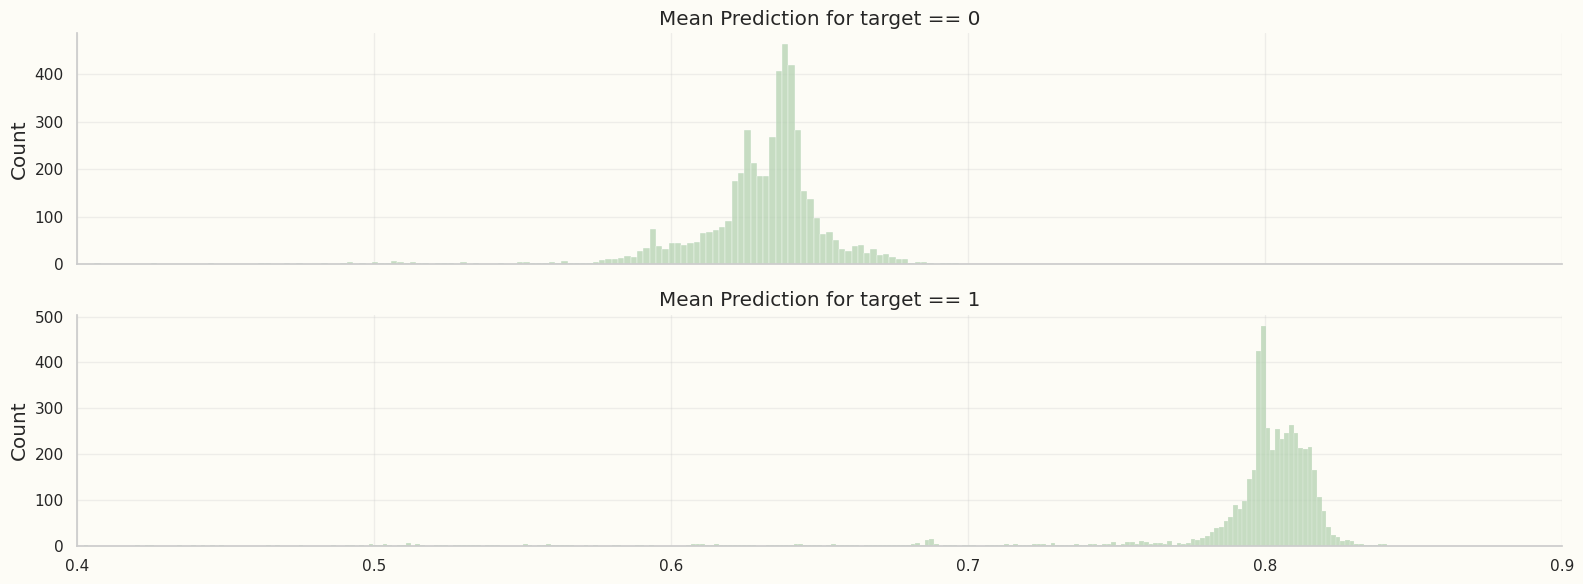

In [14]:
fig, ax = plt.subplots(2, 1, sharex=True)
sns.histplot(train_preds[train_preds.target == 0].mean(), ax=ax[0])
sns.histplot(train_preds[train_preds.target == 1].mean(), ax=ax[1])
ax[0].set_xlim([0.4, 0.9])

ax[0].set_title('Mean Prediction for target == 0')
ax[1].set_title('Mean Prediction for target == 1')
plt.tight_layout()

# Model Variance

Another key metric to validate is the variance. Good models should have a low mean and low variance on examples of the same class. Caveat: low variance does not necessarily mean that the model has high accuracy, but rather that it is precise.

Using general knowledge jargon the interpretation is:

<center>
    <img src='https://chemistrygod.com/assets/media/thumbnail/accuracy-and-precision-in-chemistry-featured-image.png', style='height:300px'>
</center>

Insights:
* The variance of the prediction's variance (what a tongue twister) is less when predicting `target==1`
* `Target==0` will be more difficult to predict as the contributions to the overall class per model are highly variable

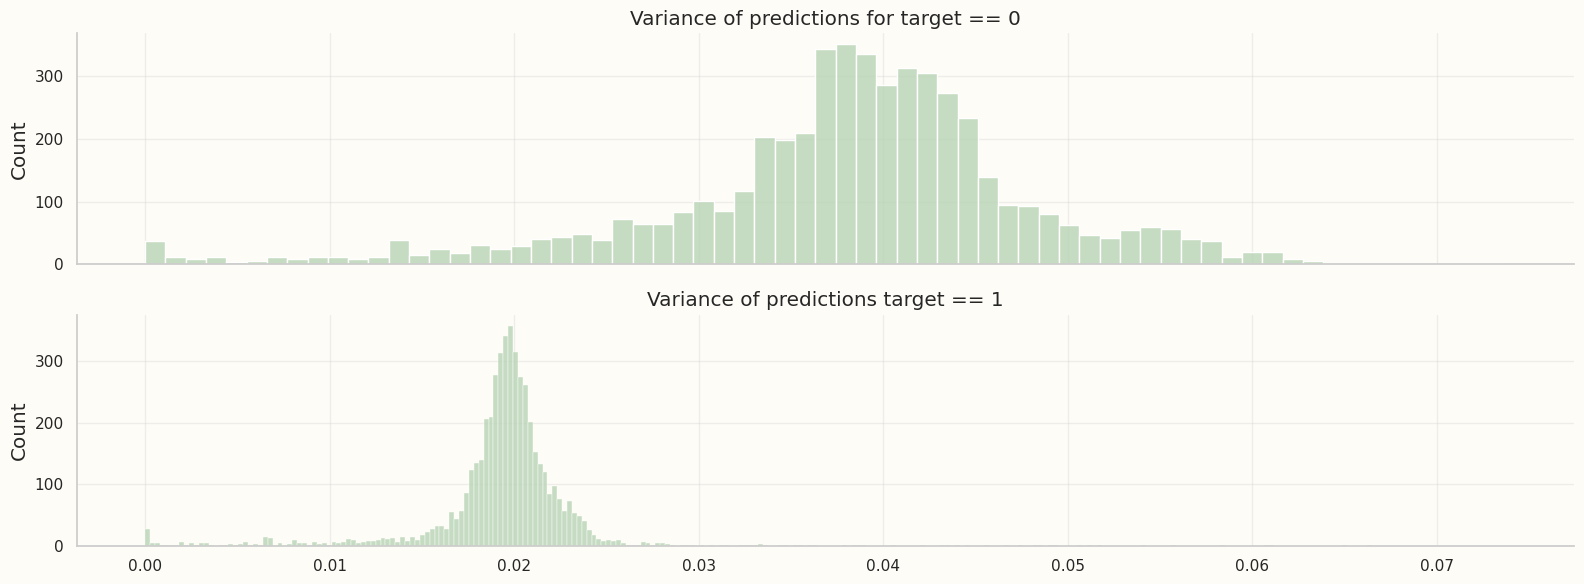

In [15]:
fig, ax = plt.subplots(2, 1, sharex=True)
sns.histplot(train_preds[train_preds.target == 0].var(), ax=ax[0])
sns.histplot(train_preds[train_preds.target == 1].var(), ax=ax[1])

ax[0].set_title('Variance of predictions for target == 0')
ax[1].set_title('Variance of predictions target == 1')
plt.tight_layout()

# Hard Examples

Some examples are harder than others, we can measure that by doing a 2D histogram using the mean and the variance per row. The intuitions behind this are:
* Low variance, mean close to the target: easy example.
* Low variance, mean away from the target: hardest examples most models predict incorrectly.
* High variance, mean away from the target: hard example some models might predict correctly.
* High variance, mean close to the target:  hard example some models might predict correctly.


Insights:
* Class 0 has high variance and high mean, these are the hardest examples.
* Class 1 has lots of outliers, ensemble will help to mitigate the effect of these.

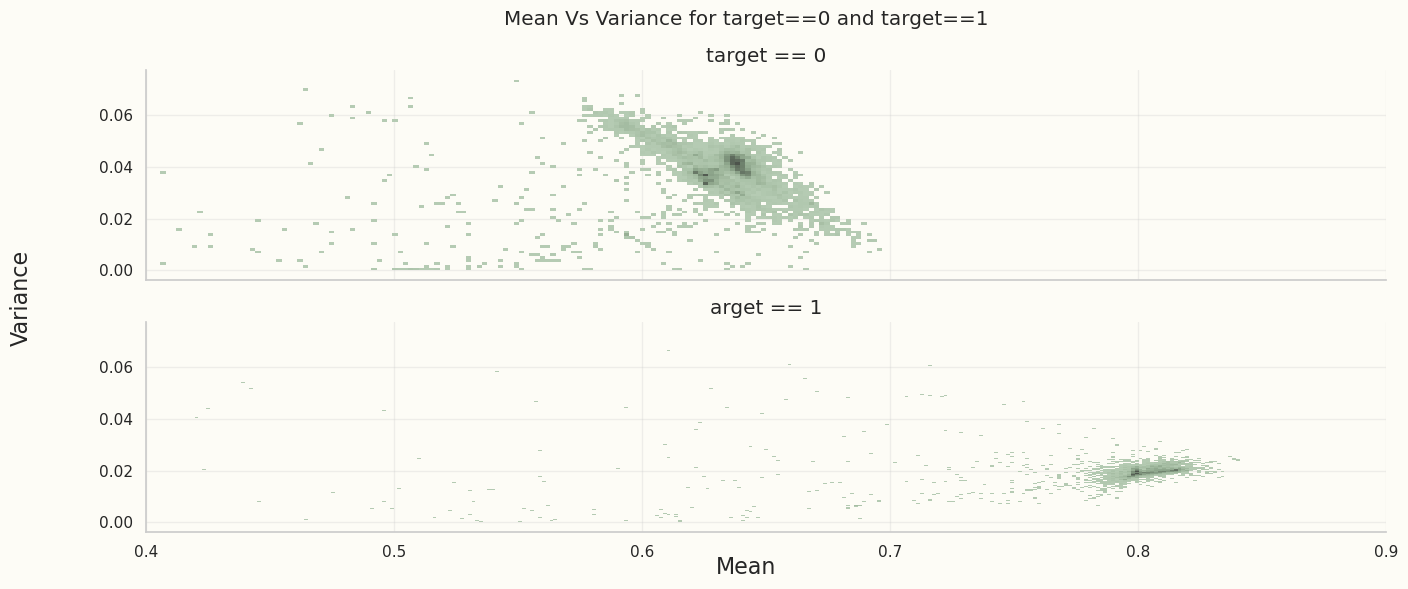

In [16]:
means_0, variances_0 = (
    train_preds[train_preds.target == 0].mean(),
    train_preds[train_preds.target == 0].var()
)

means_1, variances_1 = (
    train_preds[train_preds.target == 1].mean(),
    train_preds[train_preds.target == 1].var()
)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
sns.histplot(x=means_0, y=variances_0, ax=ax[0])
sns.histplot(x=means_1, y=variances_1, ax=ax[1])

ax[0].set_xlim([0.4, 0.9])

fig.text(0.5, 0.04, 'Mean', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'Variance', va='center', rotation='vertical', fontsize=16)
plt.suptitle('Mean Vs Variance for target==0 and target==1');
ax[0].set_title('target == 0');
ax[1].set_title('arget == 1');

# Adding Perturbations

Recall tha AUC is a metric that only considers the rank of the probabilities, adding a constant to the probabilites won't change AUC but will have an impact on the logloss. What if we had constants to the predicitos with high AUC and measure the change in the logloss?

**Insights**:
* Models were trained using unkwnon, and not available data.
* If fitting a linear model make sure to set `fit_intercept=True`

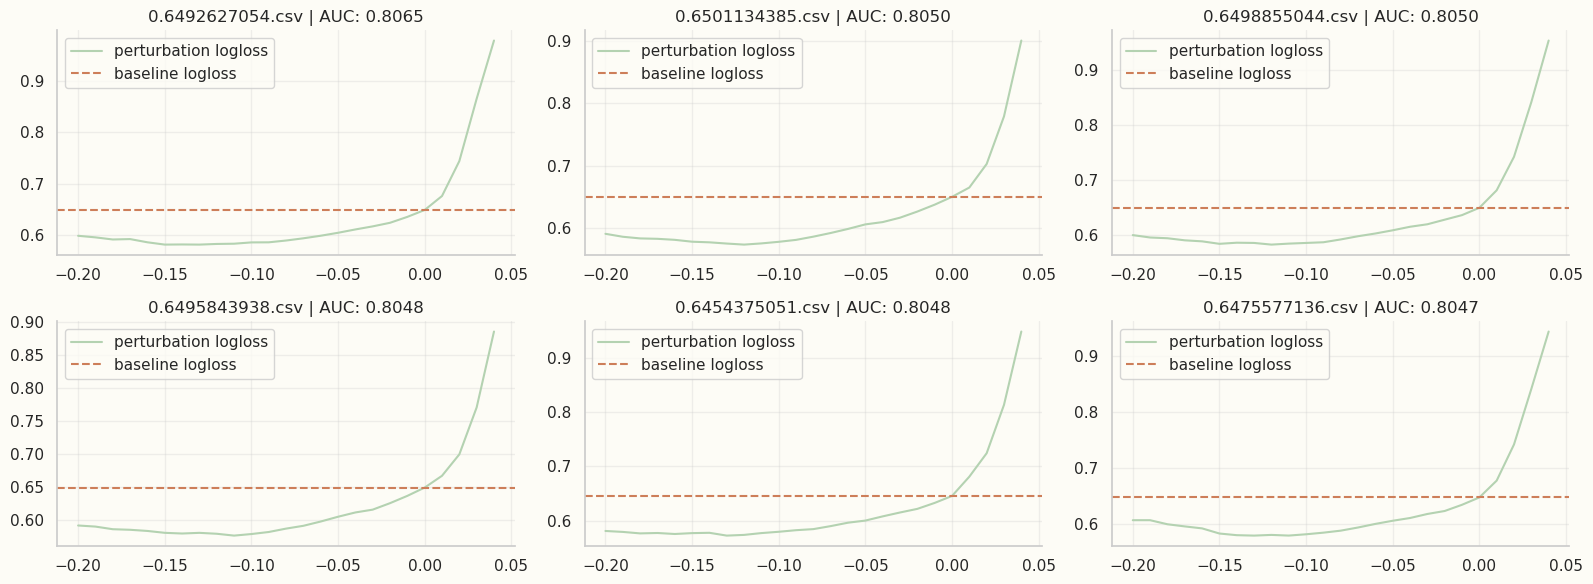

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

AUCs = train_preds.apply(lambda x: roc_auc_score(train_preds.target, x), axis=0)
log_losses = train_preds.apply(lambda x: log_loss(train_preds.target, x), axis=0)

metrics_df = pd.merge(
    AUCs.rename('auc'), log_losses.rename('logloss'),
    left_index=True, right_index=True
)

#top AUC is `target` column so let's not consider it
index = metrics_df.sort_values('auc', ascending=False).iloc[1:7].index
fig, ax = plt.subplots(2, 3)
ax = ax.flatten()
perturbations = np.arange(-2e-1, 5e-2, 0.01)
i=0

for file in index:
    perturbation_logloss = []

    for perturbation in perturbations:
        logloss = log_loss(train_preds.target, train_preds[file] + perturbation)
        perturbation_logloss.append(logloss)

    ax[i].plot(
        perturbations, perturbation_logloss, label='perturbation logloss'
    )
    ax[i].axhline(
        metrics_df.loc[file, 'logloss'], linestyle='--',
        color=palette[3], label='baseline logloss'
    )
    ax[i].legend()
    ax[i].set_title(file + f' | AUC: {metrics_df.loc[file, "auc"]:.4f}', fontsize=12)
    i+=1
    
plt.tight_layout()

## Compare logloss with pertubed logloss

For the first 1k submissions sorted by AUC 100% reduces the logloss by adding some perturbation. Mean reduce is about 13% from the original loss, this can serve us as a baseline.

In [18]:
%%time
index = metrics_df.sort_values('auc', ascending=False).iloc[1:1001].index
min_losses = []

for file in track(index):
    perturbation_logloss = []

    for perturbation in perturbations:
        #dont calculate logloss is perturbation is zero
        if abs(perturbation) < 1e-10:
            continue
        logloss = log_loss(train_preds.target, train_preds[file] + perturbation)
        perturbation_logloss.append(logloss)

    min_losses.append(min(perturbation_logloss))
    
display((metrics_df.loc[index, 'logloss'] > np.array(min_losses)).value_counts(True))
print(
    'Mean reduce',
    ((1 - np.array(min_losses)/metrics_df.loc[index, 'logloss']).mean())
)

Output()

True    1.0
Name: logloss, dtype: float64

Mean reduce 0.13085478561835454

CPU times: user 2min 42s, sys: 943 ms, total: 2min 43s
Wall time: 2min 43s


# Correlations

**Insights**:
* There are perfectly correlated columns, we should one of them to reduce features and increase stability of linear models.

In [19]:
READ_CORRELATIONS = True

if READ_CORRELATIONS:
    correlations = pd.read_parquet(
        '../input/tps-nov21-concat-submissions-float64/correlation_matrix.parquet'
    )
else:
    correlations = train_preds.corr()
    correlations.to_parquet('correlations.parquet', compression='gzip')

#upper triangle mask
mask = np.triu(np.ones_like(correlations), 1).astype(bool)

correlations.where(mask).stack().abs().sort_values().tail(20)

0.6839593916.csv  0.6951117716.csv    0.999997
0.7149448959.csv  0.7267437211.csv    0.999998
0.6941908406.csv  0.6942817011.csv    0.999998
0.6951117716.csv  0.6885464000.csv    0.999998
0.7123557934.csv  0.7122715619.csv    0.999998
0.6855845303.csv  0.6857025585.csv    1.000000
0.6814483512.csv  0.6814466748.csv    1.000000
0.7126018652.csv  0.7125879501.csv    1.000000
0.6839593916.csv  0.6885464000.csv    1.000000
0.6884713711.csv  0.6979541400.csv    1.000000
0.6975625595.csv  0.6975624508.csv    1.000000
0.6975624508.csv  0.6807226664.csv    1.000000
0.7036398090.csv  0.7027673425.csv    1.000000
0.7325961492.csv  0.7315714039.csv    1.000000
0.6975625595.csv  0.6807226664.csv    1.000000
0.6912107465.csv  0.6507688973.csv    1.000000
0.6945358038.csv  0.6902864150.csv    1.000000
0.6902670942.csv  0.6800153562.csv    1.000000
0.6910899199.csv  0.6788040808.csv    1.000000
0.7134651190.csv  0.7134651201.csv    1.000000
dtype: float64

# Cross Validation

Given the lack of information about the id of prediction and balanced dataset, a normal KFold will do the trick. For a more robust approach, one might consider using ReapeatedKFold to asses the generalization under different seeds.

In [20]:
from sklearn.model_selection import KFold
cv = KFold()

# Train Model

Given the amount of decimals it's important to not overfit the data. This attemp uses a LGBM (I tried a Logistic Regression previosly but LGBM seems to work better). Of course you can do the ensemble of the ensemble but for now let's keep it simple and attemp to figure out which are the best initial approaches.

In [21]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_validate

model = LGBMClassifier(device='gpu', max_depth=3, random_state=42)
y = train_preds.target
X = train_preds.drop(columns=['target'])

results = cross_validate(
    model,
    X, y,
    cv=cv,
    scoring='neg_log_loss',
    return_train_score=True,
    verbose=1
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.6min finished


There are little signs of overfitting, further improvement of model should include:
    
* Feature Selection
* More Regularization (`num_leaves` ⤵, `max_bin` ⤵, `lambda_l1` ⤴)
* Other KFold seed

In [22]:
print(results)
print(np.mean(results['test_score']))

{
    'fit_time': array([34.6551168 , 27.94612217, 27.15751052, 28.63611794, 27.0809021 ]),
    'score_time': array([0.46286583, 0.41973042, 0.47271037, 0.45716906, 0.44076824]),
    'test_score': array([-0.52923448, -0.52913494, -0.52691345, -0.5271045 , -0.51900144]),
    'train_score': array([-0.48622144, -0.48381256, -0.48716833, -0.48477832, -0.48822391])
}

-0.5262777611655804

# Generate Test Prediction

In [23]:
model.fit(X, y)
submission = pd.read_csv('../input/tabular-playground-series-nov-2022/sample_submission.csv', index_col=0)
submission_preds = model.predict_proba(test_preds)[:, 1]
submission['pred'] = submission_preds
submission.to_csv('submission.csv')